##### Copyright 2020 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/simclr/blob/master/tf2/colabs/finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## SimCLR: A Simple Framework for Contrastive Learning of Visual Representations

This colab demonstrates how to load pretrained/finetuned SimCLR models from hub modules for fine-tuning

The checkpoints are accessible in the following Google Cloud Storage folders.

* Pretrained SimCLRv2 models with a linear classifier: [gs://simclr-checkpoints-tf2/simclrv2/pretrained](https://console.cloud.google.com/storage/browser/simclr-checkpoints-tf2/simclrv2/pretrained)
* Fine-tuned SimCLRv2 models on 1% of labels: [gs://simclr-checkpoints-tf2/simclrv2/finetuned_1pct](https://console.cloud.google.com/storage/browser/simclr-checkpoints-tf2/simclrv2/finetuned_1pct)
* Fine-tuned SimCLRv2 models on 10% of labels: [gs://simclr-checkpoints-tf2/simclrv2/finetuned_10pct](https://console.cloud.google.com/storage/browser/simclr-checkpoints-tf2/simclrv2/finetuned_10pct)
* Fine-tuned SimCLRv2 models on 100% of labels: [gs://simclr-checkpoints-tf2/simclrv2/finetuned_100pct](https://console.cloud.google.com/storage/browser/simclr-checkpoints-tf2/simclrv2/finetuned_100pct)
* Supervised models with the same architectures: [gs://simclr-checkpoints-tf2/simclrv2/pretrained](https://console.cloud.google.com/storage/browser/simclr-checkpoints-tf2/simclrv2/pretrained)

Use the corresponding checkpoint / hub-module paths for accessing the model. For example, to use a pre-trained model (with a linear classifier) with ResNet-152 (2x+SK), set the path to `gs://simclr-checkpoints-tf2/simclrv2/pretrained/r152_2x_sk1`.

https://drive.google.com/drive/folders/1ncHuN2p21PK-DB48sV2SSBCin6GhxNOU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp '/content/drive/MyDrive/Deepak/FourthBrain/MachineLearningEngineerCourse/Capstone/Retinal-OCT/data_util.py' data_util.py
!cp '/content/drive/MyDrive/Deepak/FourthBrain/MachineLearningEngineerCourse/Capstone/Retinal-OCT/lars_optimizer.py' lars_optimizer.py

In [ ]:
import re
import numpy as np
import os
import pandas as pd
import matplotlib.image as mpimg
import sklearn
import sklearn.metrics
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator

import tensorflow.compat.v2 as tf
tf.compat.v1.enable_v2_behavior()
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib
import matplotlib.pyplot as plt
import data_util
import lars_optimizer

In [ ]:
%%time
%%bash
if [ -d oct/data ]
then
  echo "data already exists"
else 
  mkdir -p oct/data
  unzip -d oct/data drive/MyDrive/Deepak/FourthBrain/MachineLearningEngineerCourse/Capstone/Retinal-OCT/kermany2018.zip
fi

data already exists
CPU times: user 5.11 ms, sys: 10.1 ms, total: 15.2 ms
Wall time: 28.6 ms


In [ ]:
def replace(parent):
    for path, folders, files in os.walk(parent):
        for f in files:
          os.rename(os.path.join(path, f), os.path.join(path, f.replace(' ', '')))
        for i in range(len(folders)):
          new_name = folders[i].replace(' ', '')
          os.rename(os.path.join(path, folders[i]), os.path.join(path, new_name))
          folders[i] = new_name
replace('/content/oct/data/')

In [ ]:
NUM_CLASSES = 4
def create_df_all_data():  
  from pathlib import Path
  working_directory_path = '/content/oct/data/OCT2017'
  listOfFiles = list()
  for (dirpath, dirnames, filenames) in os.walk(working_directory_path):
      # print("dirpath ={}, dirname = {}, filename = {}".format(dirpath, dirnames, filenames))
      for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        file_extension = Path(filepath).suffix
        if file_extension == '.jpeg':
          middle_str = filepath[len(working_directory_path + "/"):len(filepath) - len("/" + filename)]
          oct_type = middle_str[middle_str.rindex("/")+1:]
          middle_str = middle_str[:middle_str.rindex("/"+ oct_type) ]
          # print(middle_str)
          # analysis_type = middle_str[middle_str.rindex("/")+1:]
          analysis_type = middle_str      
          file_details = [analysis_type, oct_type, filename , filepath ]
          # if oct_type != 'DRUSEN': # let's try running without DRUSEN
          listOfFiles.append(file_details)
  temp_df = pd.DataFrame(listOfFiles, columns=["analysis_type", "oct_type", 'filename','filepath' ])
  temp_df.sort_values(by=['filename'])
  temp_df = temp_df.drop_duplicates(subset = ['oct_type', 'filename'], keep = 'last').reset_index(drop = True)
  return temp_df
temp_df = create_df_all_data()
temp_df.head()

,analysis_type,oct_type,filename,filepath
0,train,NORMAL,NORMAL-3720368-3.jpeg,/content/oct/data/OCT2017/train/NORMAL/NORMAL-...
1,train,NORMAL,NORMAL-8111718-4.jpeg,/content/oct/data/OCT2017/train/NORMAL/NORMAL-...
2,train,NORMAL,NORMAL-9772210-1.jpeg,/content/oct/data/OCT2017/train/NORMAL/NORMAL-...
3,train,NORMAL,NORMAL-8182813-3.jpeg,/content/oct/data/OCT2017/train/NORMAL/NORMAL-...
4,train,NORMAL,NORMAL-3225481-4.jpeg,/content/oct/data/OCT2017/train/NORMAL/NORMAL-...


In [ ]:
def print_image_counts(image_df):
 print(image_df.groupby(['analysis_type','oct_type']).size().to_frame('Image Count'))
print_image_counts(temp_df)

                        Image Count
analysis_type oct_type             
test          CNV               242
              DME               242
              DRUSEN            242
              NORMAL            242
train         CNV             36966
              DME             11172
              DRUSEN           8370
              NORMAL          26097
val           CNV                 8
              DME                 8
              DRUSEN              8
              NORMAL              8


In [ ]:
# take minimum number of images from each category
def get_plain_vanilla_undersampled_df(_temp_df):
  # balanced_df = _temp_df.copy()
  _g = _temp_df.groupby('oct_type',group_keys=False)
  _balanced_df = pd.DataFrame(_g.apply(lambda x: x.sample(_g.size().min(), random_state=42).reset_index(drop=True)))
  # balanced_df.head()
  return _balanced_df

# take certain percentage over the minimum number of images from each category
def get_undersampled_df(_temp_df, min_pct = 0.6):
  _g = _temp_df.groupby('oct_type',group_keys=False)
  max_size= int((_g.size().min()/min_pct))
  _balanced_df = pd.DataFrame(_g.apply(lambda x: x.sample(min(len(x), max_size), random_state=42).reset_index(drop=True)))
  return _balanced_df

balanced_df = get_plain_vanilla_undersampled_df(temp_df)
# balanced_df = get_undersampled_df(temp_df)
#balanced_df = temp_df.copy()
print(balanced_df.groupby(['oct_type']).size().to_frame('Image Count'))
print("total images used for this analysis = {}".format(balanced_df.shape[0]))

          Image Count
oct_type             
CNV              8620
DME              8620
DRUSEN           8620
NORMAL           8620
total images used for this analysis = 34480


In [ ]:
_train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42, stratify=balanced_df.oct_type)
train_df, valid_df = train_test_split(_train_df, test_size=0.25, random_state=42, stratify=_train_df.oct_type) # 0.25 x 0.8 = 0.2
print("train_df shape = {}".format(train_df.shape))
print("valid_df shape = {}".format(valid_df.shape))
print("test_df shape = {}".format(test_df.shape))

train_df shape = (20688, 4)
valid_df shape = (6896, 4)
test_df shape = (6896, 4)


In [ ]:
IMAGE_SIZE = 256
TRAIN_BATCH_SIZE=32
VALIDATION_BATCH_SIZE=32
TEST_BATCH_SIZE =32
def image_preprocess_simCLR(img):
  _img = data_util.preprocess_image(img, IMAGE_SIZE, IMAGE_SIZE, is_training=False, color_distort=False)
  return _img

# https://theailearner.com/2019/07/06/data-augmentation-with-keras-imagedatagenerator/
# train_datagen = ImageDataGenerator(rescale=1./255,samplewise_center=True,samplewise_std_normalization=True, rotation_range=10., width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, channel_shift_range=0.05, horizontal_flip=True) ## transformations are not providing better metrics
train_datagen = ImageDataGenerator(rescale=1./255,samplewise_center=True,samplewise_std_normalization=True,data_format="channels_last")  #, preprocessing_function=image_preprocess_simCLR) #, preprocessing_function=image_preprocess_simCLR
validation_datagen = ImageDataGenerator(rescale=1./255,samplewise_center=True,samplewise_std_normalization=True)
test_datagen = ImageDataGenerator(rescale=1./255,samplewise_center=True,samplewise_std_normalization=True)

train_generator = train_datagen.flow_from_dataframe(train_df, x_col='filepath', y_col='oct_type',class_mode='categorical',batch_size=TRAIN_BATCH_SIZE,target_size=(IMAGE_SIZE,IMAGE_SIZE))
validation_generator = validation_datagen.flow_from_dataframe(valid_df, x_col='filepath', y_col='oct_type',class_mode='categorical',batch_size=VALIDATION_BATCH_SIZE,shuffle=False, target_size=(IMAGE_SIZE,IMAGE_SIZE))
test_generator = test_datagen.flow_from_dataframe(test_df, x_col='filepath', y_col='oct_type',class_mode='categorical',batch_size=TEST_BATCH_SIZE,shuffle=False,target_size=(IMAGE_SIZE,IMAGE_SIZE))

Found 20688 validated image filenames belonging to 4 classes.
Found 6896 validated image filenames belonging to 4 classes.
Found 6896 validated image filenames belonging to 4 classes.


In [ ]:
print(train_generator.class_indices)
print(train_generator.target_size)
print(train_generator.batch_size)
# print(train_generator.num_classes)

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
(256, 256)
32


In [ ]:
Labels={i:k for i, k in enumerate(list(train_generator.class_indices.keys())) }
def GetLabel(key):
    return Labels[key]
print(Labels)

{0: 'CNV', 1: 'DME', 2: 'DRUSEN', 3: 'NORMAL'}


The image resolution is =(256, 256)


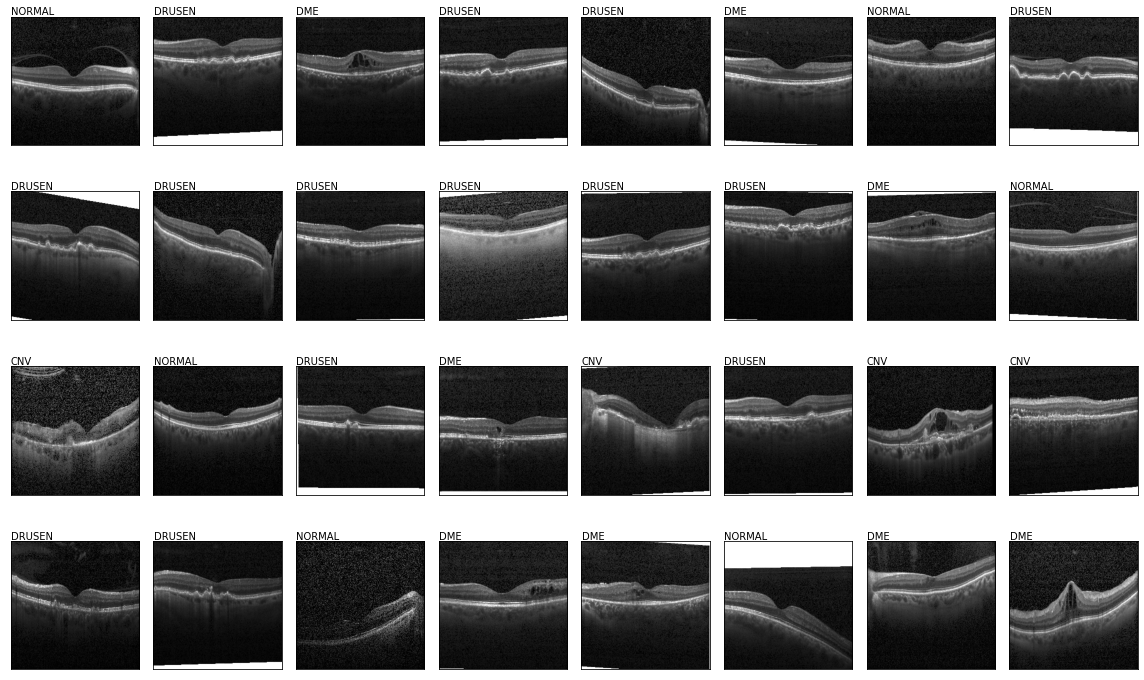

In [ ]:
plt.figure(figsize=(16,10))
batch = next(train_generator)
images = batch[0]
labels = batch[1]

for i in range(len(batch[0])):
    plt.subplot(4,8,i+1)
    img = images[i][:,:,0] 
    if i==0:
        print("The image resolution is ={}".format(img.shape))
    plt.imshow(img,cmap='gray')
    # print(labels[i])
    plt.text(0, -5, '{}'.format(GetLabel(np.argmax(labels[i]))), color='k')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
#@title Load module and construct the computation graph

learning_rate = 0.1
momentum = 0.9
weight_decay = 0.

class Model(tf.keras.Model):
  def __init__(self, path):
    super(Model, self).__init__()
    self.saved_model = tf.saved_model.load(path)
    self.dense_layer = tf.keras.layers.Dense(units=NUM_CLASSES, name="head_supervised_new")
    self.optimizer = lars_optimizer.LARSOptimizer(
      learning_rate,
      momentum=momentum,
      weight_decay=weight_decay,
      exclude_from_weight_decay=['batch_normalization', 'bias', 'head_supervised'])

  def call(self, x):
    with tf.GradientTape() as tape:
      outputs = self.saved_model(x[0], trainable=False)
      # print(outputs)
      logits_t = self.dense_layer(outputs['final_avg_pool'])      
      # _labels =  tf.one_hot(x[1], NUM_CLASSES)
      # print('x[1].shape = {}; logits_t.shape = {}; _labels.shape={}'.format(x[1].shape, logits_t.shape,_labels.shape))
      loss_t = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels =x[1], logits=logits_t))
      dense_layer_weights = self.dense_layer.trainable_weights
      print('Variables to train:', dense_layer_weights)
      grads = tape.gradient(loss_t, dense_layer_weights)
      self.optimizer.apply_gradients(zip(grads, dense_layer_weights))
    return loss_t, x[0], logits_t, x[1]

model = Model("gs://simclr-checkpoints-tf2/simclrv2/finetuned_1pct/r50_2x_sk1/saved_model/")
# model = Model("gs://simclr-checkpoints-tf2/simclrv2/finetuned_100pct/r50_1x_sk0/saved_model/")
model.compile(loss='sparse_categorical_crossentropy', metrics=['acc'])
# Remove this for debugging.  
@tf.function
def train_step(x):
  return model(x)

In [ ]:
import time
def train_simclr(generator, epochs=10):
    steps = len(generator.filenames)//generator.batch_size 
    for e in range(epochs):
        total_correct = 0 
        total_processed = 0 
        total_loss = 0
        epoch_start_time = time.time()
        for it in range(steps):
            x = next(generator)
            # print ('x[1] ==> {}'.format(x[1]))
            # xx = (x[0], np.int32(x[1]))
            # print ('xx[1] ==> {}'.format(xx[1]))
            loss, image, logits, labels = train_step(x)
            logits = logits.numpy()
            labels = labels.numpy().argmax(-1)
            pred = logits.argmax(-1)
            correct = np.sum(pred == labels)
            total = labels.size
            total_processed += total
            total_loss += loss
            total_correct += correct
            if (it+1) % 300 == 0:
                print("[Epoch-{}/Step-{}] - Loss: {:.4f}, Correct: {:.4f}".format(e +1, it+1, total_loss/total_processed, total_correct/float(total_processed)))
            # if it == 1:
            #   break
        run_time = (time.time() - epoch_start_time) 
        minutes, seconds = divmod(run_time, 60)
        timeS = '{:.0f}m:{:.0f}s'.format(minutes, seconds)
        print(f"[Epoch-{e+1}] - Loss: {total_loss/total_processed:.4f}; Total-Correct: {total_correct/total_processed:.4f}; Total time taken: {timeS}")

In [ ]:
train_simclr(train_generator, epochs=30)

Variables to train: [<tf.Variable 'model_1/head_supervised_new/kernel:0' shape=(4096, 4) dtype=float32>, <tf.Variable 'model_1/head_supervised_new/bias:0' shape=(4,) dtype=float32>]
Variables to train: [<tf.Variable 'model_1/head_supervised_new/kernel:0' shape=(4096, 4) dtype=float32>, <tf.Variable 'model_1/head_supervised_new/bias:0' shape=(4,) dtype=float32>]
[Epoch-1/Step-300] - Loss: 0.0556, Correct: 0.3003
[Epoch-1/Step-600] - Loss: 0.0537, Correct: 0.3257
Variables to train: [<tf.Variable 'model_1/head_supervised_new/kernel:0' shape=(4096, 4) dtype=float32>, <tf.Variable 'model_1/head_supervised_new/bias:0' shape=(4,) dtype=float32>]
[Epoch-1] - Loss: 0.0536; Total-Correct: 0.3274; Total time taken: 5m:47s
[Epoch-2/Step-300] - Loss: 0.0486, Correct: 0.3806
[Epoch-2/Step-600] - Loss: 0.0486, Correct: 0.3841
[Epoch-2] - Loss: 0.0487; Total-Correct: 0.3829; Total time taken: 5m:33s
[Epoch-3/Step-300] - Loss: 0.0466, Correct: 0.4084
[Epoch-3/Step-600] - Loss: 0.0466, Correct: 0.4087


In [1]:
train_simclr(train_generator, epochs=30)

NameError: ignored

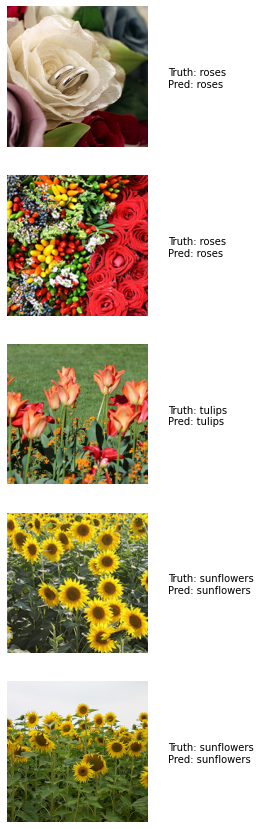

In [ ]:
#@title Plot the images and predictions
fig, axes = plt.subplots(5, 1, figsize=(15, 15))
for i in range(5):
  axes[i].imshow(image[i])
  true_text = tf_flowers_labels[labels[i]]
  pred_text = tf_flowers_labels[pred[i]]
  axes[i].axis('off')
  axes[i].text(256, 128, 'Truth: ' + true_text + '\n' + 'Pred: ' + pred_text)